# Train WPD3 (WebPage Domain) detection model for phishing detection

Using new collected dataset "Pharec_toy_dataset_v1", modified by decreasing number of apple images

## Imports

In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

In [2]:
dataset_dir = pathlib.Path("../toy_dataset/")
model_dir = pathlib.Path('../phi_models/')
checkpoint_dir = pathlib.Path('../phi_checkpoints/')

In [3]:
dataset_dirs = os.listdir(dataset_dir)
print(dataset_dirs)

['phish_images', 'trusted_images']


In [4]:
dataset_phish_dir = dataset_dirs[0]
dataset_trusted_dir = dataset_dirs[1]

In [5]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2022-09-06_19;51;12.137745


## Params

In [6]:
model_name = "wpd4"
batch_size = 16
img_height = 683 // 2
img_width = 1024 // 2

rest_split_ratio = 0.2
test_split_ratio = 0.2

## Load dataset

In [8]:
train_trusted_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/dataset_trusted_dir,
  validation_split=rest_split_ratio,
  subset="training",
  seed=1324,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  smart_resize=True
)

Found 6801 files belonging to 69 classes.
Using 5441 files for training.


In [9]:
train_trusted_ds.cardinality().numpy() * 16

5456

In [10]:
rest_trusted_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/dataset_trusted_dir,
  #label_mode = 'categorical',
  validation_split=rest_split_ratio,
  subset="validation",
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  smart_resize=True
)

Found 6801 files belonging to 69 classes.
Using 1360 files for validation.


In [11]:
class_names = train_trusted_ds.class_names
num_classes = len(class_names)
print("Number of classes", num_classes)
print(list(enumerate(class_names)))

Number of classes 69
[(0, 'aliexpress_com_images'), (1, 'apple_com_images'), (2, 'balady_gov_sa_images'), (3, 'citc_gov_sa_images'), (4, 'hrsd_gov_sa_images'), (5, 'loungekey_com_images'), (6, 'mewa_gov_sa_images'), (7, 'mlsd_gov_sa_images'), (8, 'moe_gov_sa_images'), (9, 'moh_gov_sa_images'), (10, 'najiz_sa_images'), (11, 'portal_ca_gov_sa_images'), (12, 'sa_iherb_com_images'), (13, 'sa_zain_com_images'), (14, 'sabq_org_images'), (15, 'store_steampowered_com_images'), (16, 'stripe_com_images'), (17, 'thmanyah_com_images'), (18, 'www_airarabia_com_images'), (19, 'www_airbnb_com_images'), (20, 'www_al-jazirah_com_images'), (21, 'www_alahli_com_images'), (22, 'www_alibaba_com_images'), (23, 'www_americanexpress_com_images'), (24, 'www_americanexpress_com_sa_images'), (25, 'www_anb_com_sa_images'), (26, 'www_aramex_com_images'), (27, 'www_argaam_com_images'), (28, 'www_att_com_images'), (29, 'www_bankaljazira_com_images'), (30, 'www_binance_com_images'), (31, 'www_coursera_com_images'), (

In [12]:
# for i in range(num_classes):
    # print(i, class_names[i], len(list(train_trusted_ds.unbatch().filter(lambda x, y: tf.math.equal(y, i)).as_numpy_iterator())))

In [13]:
# test_phi_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   # dataset_dir/dataset_phish_dir,
#   dataset_dir/dataset_phish_dir,
#   seed=1324,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

In [14]:
# rest_phi_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   dataset_dir/dataset_phish_dir,
#   validation_split=rest_split_ratio,
#   subset="validation",
#   seed=1324,
#   image_size=(img_height, img_width),
#   batch_size=batch_size

In [15]:
# train_ds = train_trusted_ds.concatenate(train_phi_ds)
# rest_ds = rest_trusted_ds.concatenate(rest_phi_ds)
train_ds = train_trusted_ds
rest_ds = rest_trusted_ds

In [16]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

85


In [17]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio))

In [18]:
train_ds.cardinality().numpy()

341

In [19]:
val_ds.cardinality().numpy()

68

In [20]:
test_ds.cardinality().numpy()

17

## Visualize data

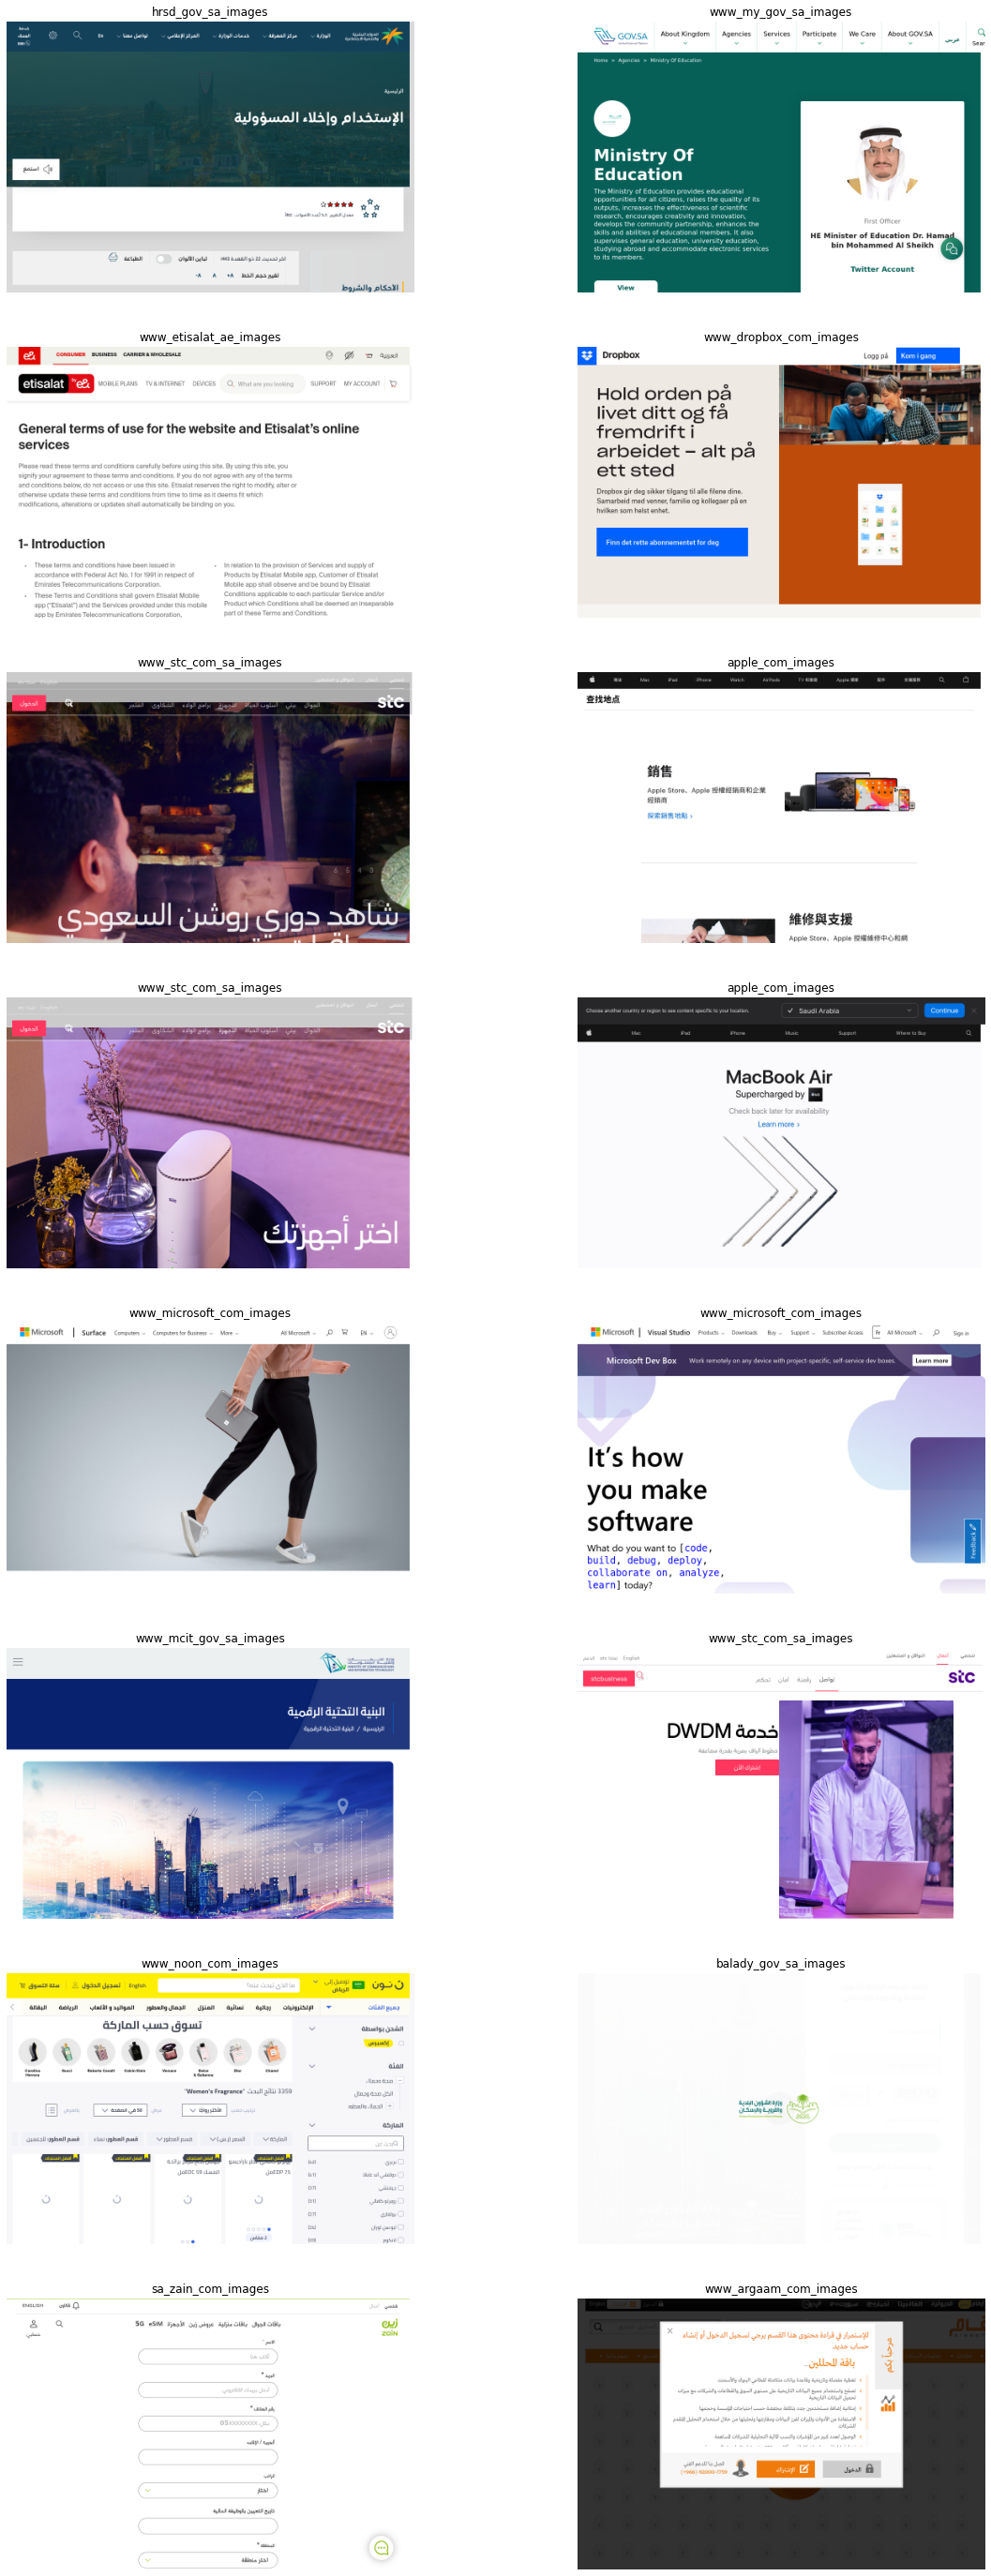

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 50))
# print([ (i,l) for i, l intrain_ds..take(1).as_numpy_iterator()])
for images, labels in train_trusted_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Tune dataset

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
shuffle_size = 48
train_ds = train_ds.cache().shuffle(shuffle_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarize the dataset

In [23]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Model

In [24]:
dropout_prob1 = 0.0005
dropout_prob2 = 0.01
act_reg_rate1 = 0.008
act_reg_rate2 = 0.008
reg_rate1 = 0.0001
reg_rate2 = 0.00005
activation_function='relu'
model = Sequential([
  # layers.Dropout(dropout_prob1, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='valid', activation=activation_function, use_bias=False, input_shape=(img_height, img_width, 3),
                # kernel_regularizer=regularizers.l1(reg_rate1),
                kernel_regularizer=regularizers.l1_l2(reg_rate1, reg_rate1),
                # activity_regularizer=regularizers.l1_l2(act_reg_rate1, reg_rate1)
               ),
  layers.MaxPooling2D(),
  layers.Dropout(dropout_prob2),
  layers.Conv2D(32, 3, padding='valid', activation=activation_function, use_bias=False,
                kernel_regularizer=regularizers.l1(reg_rate1),
                # kernel_regularizer=regularizers.l1_l2(reg_rate1, reg_rate1),
                # activity_regularizer=regularizers.l1_l2(act_reg_rate1, reg_rate1)
               ),
  layers.MaxPooling2D(),
  layers.Dropout(dropout_prob2),
  layers.Conv2D(24, 3, padding='valid', activation=activation_function, use_bias=False,
                kernel_regularizer=regularizers.l1(reg_rate2),
                # kernel_regularizer=regularizers.l1_l2(reg_rate2, reg_rate2),
                # activity_regularizer=regularizers.l1_l2(act_reg_rate2, reg_rate2)
               ),
  layers.MaxPooling2D(),
  layers.Dropout(dropout_prob2),
  layers.Conv2D(16, 3, padding='valid', activation=activation_function, use_bias=False,
                kernel_regularizer=regularizers.l1_l2(reg_rate2, reg_rate2),
                # activity_regularizer=regularizers.l1_l2(act_reg_rate2, reg_rate2)
               ),
  # layers.MaxPooling2D(),
  # layers.Conv2D(8, 3, padding='valid', activation=activation_function, use_bias=False,
                # kernel_regularizer=regularizers.l1_l2(reg_rate2, reg_rate2),
                # activity_regularizer=regularizers.l1_l2(act_reg_rate2, reg_rate2)
               # ),
  # layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(120, activation=activation_function,
              # activity_regularizer=regularizers.l2(reg_rate2, reg_rate2)
              ),
  layers.Dense(num_classes)
])


In [25]:
model.compile(
    # optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.1, nesterov=True), 
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)


In [26]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 339, 510, 64)      1728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 169, 255, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 169, 255, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 167, 253, 32)      18432     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 83, 126, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 83, 126, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 81, 124, 24)       6

## Training

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=6,
        verbose=1,
    )
]


In [28]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/50
341/341 [==============================] - 42s 105ms/step - loss: 1.6275 - accuracy: 0.6751 - val_loss: 0.5559 - val_accuracy: 0.8842

Epoch 00001: val_loss improved from inf to 0.55586, saving model to ..\phi_checkpoints\2022-09-06_19;51;12.137745_wpd4_valacc0.8842_e1
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2022-09-06_19;51;12.137745_wpd4_valacc0.8842_e1\assets
Epoch 2/50
341/341 [==============================] - 29s 86ms/step - loss: 0.5166 - accuracy: 0.8973 - val_loss: 0.3036 - val_accuracy: 0.9403

Epoch 00002: val_loss improved from 0.55586 to 0.30358, saving model to ..\phi_checkpoints\2022-09-06_19;51;12.137745_wpd4_valacc0.9403_e2
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2022-09-06_19;51;12.137745_wpd4_valacc0.9403_e2\assets
Epoch 3/50
341/341 [==============================] - 27s 78ms/step - loss: 0.2591 - accuracy: 0.9474 - val_loss: 0.2429 - val_accuracy: 0.9688

Epoch 00003: val_loss improved from 0.30358 to 0.24294, saving model to 

## Save model

In [29]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: ..\phi_models\2022-09-06_19;51;12.137745_wpd4_valacc0.9798_e43_b16.tf\assets


## Load best model

In [30]:
# change filename to the model you want to load
model_filename = "2022-09-06_19;51;12.137745_wpd4_valacc0.9816_e31"
# model2 = keras.models.load_model(
#     model_dir / model_filename,
#     compile=True)
model2 = keras.models.load_model(
    checkpoint_dir / model_filename,
    compile=True)

## Visulaize loss and acc

In [31]:
history.history

{'loss': [1.6275111436843872,
  0.5165992975234985,
  0.2590991258621216,
  0.19155289232730865,
  0.2152005136013031,
  0.1734093874692917,
  0.12375101447105408,
  0.10515493899583817,
  0.0843556672334671,
  0.08399276435375214,
  0.14980755746364594,
  0.09590291231870651,
  0.07724756002426147,
  0.06596322357654572,
  0.0619819201529026,
  0.05668463557958603,
  0.056109167635440826,
  0.05527016520500183,
  0.13136142492294312,
  0.07863865792751312,
  0.05380607023835182,
  0.04895707592368126,
  0.04570162296295166,
  0.043807681649923325,
  0.042563922703266144,
  0.041183147579431534,
  0.0698983371257782,
  0.06421229988336563,
  0.04802616685628891,
  0.040739282965660095,
  0.03917096555233002,
  0.03885398432612419,
  0.036381449550390244,
  0.034752652049064636,
  0.03385213017463684,
  0.03256695345044136,
  0.03172890841960907,
  0.08439021557569504,
  0.04750308021903038,
  0.03841615840792656,
  0.03668592870235443,
  0.03341137617826462,
  0.031818971037864685],
 '

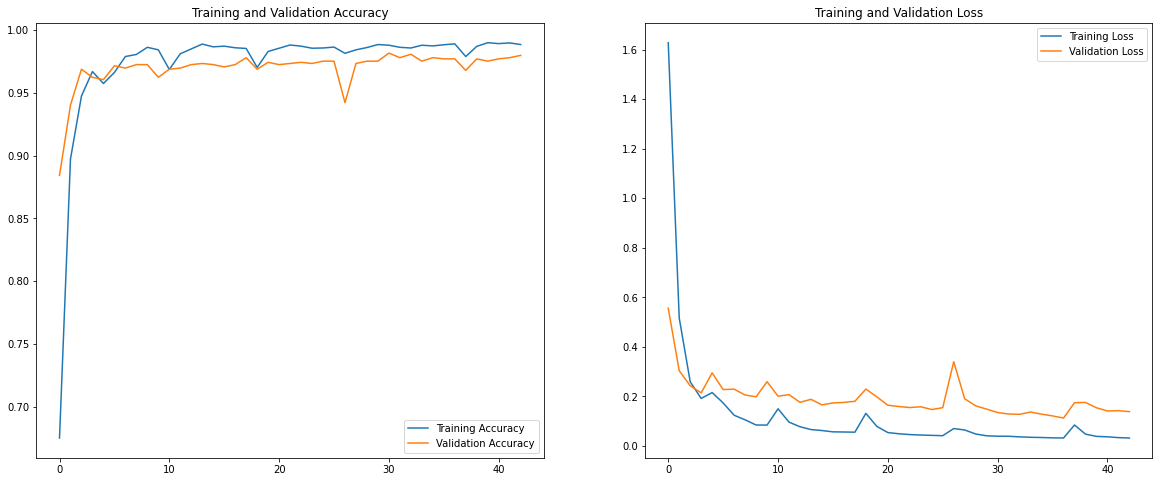

In [32]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [33]:
val_results = model.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

68/68 [==============================] - 3s 37ms/step - loss: 0.1382 - accuracy: 0.9798
val loss, val acc: [0.13818499445915222, 0.9797794222831726]


In [34]:
results = model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


17/17 [==============================] - 1s 55ms/step - loss: 0.3599 - accuracy: 0.9632
test loss, test acc: [0.35994353890419006, 0.9632353186607361]


In [35]:
val2_results = model2.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val2_results)

68/68 [==============================] - 3s 38ms/step - loss: 0.1347 - accuracy: 0.9816
val loss, val acc: [0.13467788696289062, 0.9816176295280457]


In [36]:
results2 = model2.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results2)


17/17 [==============================] - 1s 36ms/step - loss: 0.3397 - accuracy: 0.9522
test loss, test acc: [0.33966952562332153, 0.9522058963775635]
